Le but est de faire une pipeline de données avec PySpark

In [56]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from functools import reduce
from pyspark.sql.types import DoubleType


In [57]:
import sys
import pyspark
print("Python version:", sys.version)
print("PySpark version:", pyspark.__version__)


Python version: 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
PySpark version: 3.5.4


In [132]:
spark = SparkSession.builder.master('local[*]').appName("nbaApp").config("spark.sql.debug.maxToStringFields", 100).config("spark.driver.memory", "8g").config("spark.executor.memory", "8g").getOrCreate() 
#spark.sparkContext.setLogLevel("DEBUG")



Fusion des datasets

In [133]:
df1 = spark.read.csv('Datasets/regular_season_box_scores_2010_2024_part_1.csv',header=True, inferSchema=True)
df2 = spark.read.csv('Datasets/regular_season_box_scores_2010_2024_part_2.csv',header=True, inferSchema=True)
df3 = spark.read.csv('Datasets/regular_season_box_scores_2010_2024_part_3.csv',header=True, inferSchema=True)

In [134]:
dfs = [df1,df2,df3]

df = reduce(lambda df_a, df_b : df_a.unionByName(df_b), dfs)


In [135]:

print(df.count())
df = df.withColumn('MINUTES_double', round(split(col("minutes"),":")[0].cast('double') + (split(col("minutes"),":")[1].cast('double'))/60,2) ).drop('minutes')



joueurs_éligibles = df.groupBy('teamId','personName', 'personId', 'season_year').agg(countDistinct('gameId').alias('nb_matchs'), sum('MINUTES_double').alias('total_minutes')).filter((col('nb_matchs') > 40) & (col('total_minutes') > 200))


df = df.join(joueurs_éligibles, on=['personName', 'personId', 'season_year','teamId'], how='inner').withColumn(
    "Possessions",
    col("fieldGoalsAttempted") + 0.44 * col("freeThrowsAttempted") - col("reboundsOffensive") + col("turnovers")
)

print(df.count())


424478
354880


In [136]:
df = df.drop('game_date', 'matchup','teamCity', 'teamId','teamTricode', 'teamSlug','comment', 'jerseyNum','personId','threePointersPercentage','fieldGoalsPercentage','freeThrowsPercentage','nb_matchs'  )

df.printSchema()

root
 |-- personName: string (nullable = true)
 |-- season_year: string (nullable = true)
 |-- gameId: integer (nullable = true)
 |-- teamName: string (nullable = true)
 |-- position: string (nullable = true)
 |-- fieldGoalsMade: integer (nullable = true)
 |-- fieldGoalsAttempted: integer (nullable = true)
 |-- threePointersMade: integer (nullable = true)
 |-- threePointersAttempted: integer (nullable = true)
 |-- freeThrowsMade: integer (nullable = true)
 |-- freeThrowsAttempted: integer (nullable = true)
 |-- reboundsOffensive: integer (nullable = true)
 |-- reboundsDefensive: integer (nullable = true)
 |-- reboundsTotal: integer (nullable = true)
 |-- assists: integer (nullable = true)
 |-- steals: integer (nullable = true)
 |-- blocks: integer (nullable = true)
 |-- turnovers: integer (nullable = true)
 |-- foulsPersonal: integer (nullable = true)
 |-- points: integer (nullable = true)
 |-- plusMinusPoints: integer (nullable = true)
 |-- MINUTES_double: double (nullable = true)
 |-

changement format des minutes

In [137]:
df_team_stats = df.groupBy('season_year', 'teamName').agg(
    avg("assists").alias("team_AST"),
    avg("fieldGoalsMade").alias("team_FG")
)

df.count()

354880

In [138]:
df_league_stats = df.groupBy('season_year').agg(
    sum("points").alias("lg_PTS"),
    sum("fieldGoalsAttempted").alias("lg_FGA"),
    sum("reboundsOffensive").alias("lg_ORB"),
    sum("turnovers").alias("lg_TOV"),
    sum("freeThrowsAttempted").alias("lg_FTA"),
    sum("assists").alias("lg_AST"),
    sum("fieldGoalsMade").alias("lg_FG"),
    sum("freeThrowsMade").alias("lg_FT"),
    sum("reboundsTotal").alias("lg_TRB"),
    sum("foulsPersonal").alias("lg_PF")
)


In [139]:
df_league_stats = df_league_stats.withColumn('VOP', col("lg_PTS") / (col("lg_FGA") - col("lg_ORB") + col("lg_TOV") + 0.44 * col("lg_FTA"))) \
                                 .withColumn("DRB_pct",(col("lg_TRB") - col("lg_ORB")) / col("lg_TRB")) \
                                 .withColumn("factor",(2 / 3) - (0.5 * (col("lg_AST") / col("lg_FG"))) / (2 * (col("lg_FG") / col("lg_FT"))))
    


In [140]:
df_player_stats = df.groupBy("season_year", "teamName", "personName").agg(
    sum('MINUTES_double').alias('minutes'),
    sum('fieldGoalsMade').alias('fieldGoalsMade'),
    sum('fieldGoalsAttempted').alias('fieldGoalsAttempted'),
    sum('threePointersMade').alias('threePointersMade'),
    sum('threePointersAttempted').alias('threePointersAttempted'),
    sum('freeThrowsMade').alias('freeThrowsMade'),
    sum('freeThrowsAttempted').alias('freeThrowsAttempted'),
    sum('reboundsOffensive').alias('reboundsOffensive'),
    sum('reboundsDefensive').alias('reboundsDefensive'),
    sum('reboundsTotal').alias('reboundsTotal'),
    sum('assists').alias('assists'),
    sum('steals').alias('steals'),
    sum('blocks').alias('blocks'),
    sum('turnovers').alias('turnovers'),
    sum('foulsPersonal').alias('foulsPersonal'),
    sum('points').alias('points'),
    sum('plusMinusPoints').alias('plusMinusPoints'),
    count('gameId').alias('nb_matchs'),
    sum('Possessions').alias('possessions')
)


In [141]:
for stat in df_player_stats.columns:
    if stat not in ['season_year', 'teamName', 'personName']:
        df_player_stats = df_player_stats.withColumn(f"{stat}_100", (col(stat) *100 /col('possessions')))

In [142]:
df_player_stats.printSchema()

root
 |-- season_year: string (nullable = true)
 |-- teamName: string (nullable = true)
 |-- personName: string (nullable = true)
 |-- minutes: double (nullable = true)
 |-- fieldGoalsMade: long (nullable = true)
 |-- fieldGoalsAttempted: long (nullable = true)
 |-- threePointersMade: long (nullable = true)
 |-- threePointersAttempted: long (nullable = true)
 |-- freeThrowsMade: long (nullable = true)
 |-- freeThrowsAttempted: long (nullable = true)
 |-- reboundsOffensive: long (nullable = true)
 |-- reboundsDefensive: long (nullable = true)
 |-- reboundsTotal: long (nullable = true)
 |-- assists: long (nullable = true)
 |-- steals: long (nullable = true)
 |-- blocks: long (nullable = true)
 |-- turnovers: long (nullable = true)
 |-- foulsPersonal: long (nullable = true)
 |-- points: long (nullable = true)
 |-- plusMinusPoints: long (nullable = true)
 |-- nb_matchs: long (nullable = false)
 |-- possessions: double (nullable = true)
 |-- minutes_100: double (nullable = true)
 |-- fieldG

In [143]:
df_player_stats.printSchema()

root
 |-- season_year: string (nullable = true)
 |-- teamName: string (nullable = true)
 |-- personName: string (nullable = true)
 |-- minutes: double (nullable = true)
 |-- fieldGoalsMade: long (nullable = true)
 |-- fieldGoalsAttempted: long (nullable = true)
 |-- threePointersMade: long (nullable = true)
 |-- threePointersAttempted: long (nullable = true)
 |-- freeThrowsMade: long (nullable = true)
 |-- freeThrowsAttempted: long (nullable = true)
 |-- reboundsOffensive: long (nullable = true)
 |-- reboundsDefensive: long (nullable = true)
 |-- reboundsTotal: long (nullable = true)
 |-- assists: long (nullable = true)
 |-- steals: long (nullable = true)
 |-- blocks: long (nullable = true)
 |-- turnovers: long (nullable = true)
 |-- foulsPersonal: long (nullable = true)
 |-- points: long (nullable = true)
 |-- plusMinusPoints: long (nullable = true)
 |-- nb_matchs: long (nullable = false)
 |-- possessions: double (nullable = true)
 |-- minutes_100: double (nullable = true)
 |-- fieldG

In [144]:
df_player_stats = df_player_stats.join(df_team_stats, on=['season_year', 'teamName'], how='left').join(df_league_stats, on=['season_year'], how='left')



In [145]:
df_player_stats.printSchema()

root
 |-- season_year: string (nullable = true)
 |-- teamName: string (nullable = true)
 |-- personName: string (nullable = true)
 |-- minutes: double (nullable = true)
 |-- fieldGoalsMade: long (nullable = true)
 |-- fieldGoalsAttempted: long (nullable = true)
 |-- threePointersMade: long (nullable = true)
 |-- threePointersAttempted: long (nullable = true)
 |-- freeThrowsMade: long (nullable = true)
 |-- freeThrowsAttempted: long (nullable = true)
 |-- reboundsOffensive: long (nullable = true)
 |-- reboundsDefensive: long (nullable = true)
 |-- reboundsTotal: long (nullable = true)
 |-- assists: long (nullable = true)
 |-- steals: long (nullable = true)
 |-- blocks: long (nullable = true)
 |-- turnovers: long (nullable = true)
 |-- foulsPersonal: long (nullable = true)
 |-- points: long (nullable = true)
 |-- plusMinusPoints: long (nullable = true)
 |-- nb_matchs: long (nullable = false)
 |-- possessions: double (nullable = true)
 |-- minutes_100: double (nullable = true)
 |-- fieldG

In [146]:
df_player_stats = df_player_stats.withColumn("uPER",
    ((1/col("minutes")) * 
    (
        col('threePointersMade') +
        (2/3) * col("assists") +
        (2 - col("factor") * (col("team_AST") / col("team_FG"))) * col("fieldGoalsMade") +
        (col("freeThrowsMade") * 0.5 * (1 + (1 - (col("team_AST") / col("team_FG"))) + (2/3) * (col("team_AST") / col("team_FG")))) -
        col('VOP') * col("turnovers") -
        col('VOP') * col('DRB_pct') * (col("fieldGoalsAttempted") - col("fieldGoalsMade")) -
        col('VOP') * 0.44 * (0.44 + (0.56 * col('DRB_pct'))) * (col("freeThrowsAttempted") - col("freeThrowsMade")) +
        col('VOP') * (1 - col('DRB_pct')) * (col("reboundsTotal") - col("reboundsOffensive")) +
        col('VOP') * col('DRB_pct') * col("reboundsOffensive") +
        col('VOP') * col("steals") +
        col('VOP') * col('DRB_pct') * col("blocks") -
        col("foulsPersonal") * ((col("lg_FT") / col("lg_PF")) - 0.44 * (col("lg_FTA") / col("lg_PF") * col('VOP'))
    )
)))

In [147]:
df_player_stats = df_player_stats.withColumn("uPER_weighted", col("uPER") * col("minutes"))

league_uPER = df_player_stats.agg(
    (sum("uPER_weighted") / sum("minutes")).alias("lg_uPER")
).collect()[0]["lg_uPER"]

In [148]:
print(league_uPER)

0.3087296130901122


In [149]:
df_player_stats = df_player_stats.withColumn("PER", round(col("uPER") * (15 / lit(league_uPER)), 2))


In [151]:
df_player_stats = df_player_stats.withColumn(
    "TS%",
    when(
        (col("fieldGoalsAttempted") + 0.44 * col("freeThrowsAttempted")) > 0,
        col("points") / (2 * (col("fieldGoalsAttempted") + 0.44 * col("freeThrowsAttempted")))
    ).otherwise(0)
)

In [152]:
df_player_stats.filter(df_player_stats['season_year'] == "2017-18").select('season_year',  'personName', 'PER', 'minutes').orderBy(col('season_year').desc(),col('PER').desc()).show(5)

+-----------+--------------------+-----+------------------+
|season_year|          personName|  PER|           minutes|
+-----------+--------------------+-----+------------------+
|    2017-18|        James Harden|29.11|2550.8100000000004|
|    2017-18|       Anthony Davis|28.91| 2727.290000000001|
|    2017-18|       Stephen Curry|28.13|1630.8100000000004|
|    2017-18|        LeBron James|27.87|3025.6700000000005|
|    2017-18|Giannis Antetokou...|26.58|2756.2299999999996|
+-----------+--------------------+-----+------------------+
only showing top 5 rows



In [153]:
df_player_avg = df_player_stats \
    .withColumn("MPG", round(col("minutes_100") / col("nb_matchs"), 2)) \
    .withColumn("PPG", round(col("points_100") / col("nb_matchs"), 2)) \
    .withColumn("FGM_PG", round(col("fieldGoalsMade_100") / col("nb_matchs"), 2)) \
    .withColumn("FGA_PG", round(col("fieldGoalsAttempted_100") / col("nb_matchs"), 2)) \
    .withColumn("3PM_PG", round(col("threePointersMade_100") / col("nb_matchs"), 2)) \
    .withColumn("3PA_PG", round(col("threePointersAttempted_100") / col("nb_matchs"), 2)) \
    .withColumn("FTM_PG", round(col("freeThrowsMade_100") / col("nb_matchs"), 2)) \
    .withColumn("FTA_PG", round(col("freeThrowsAttempted_100") / col("nb_matchs"), 2)) \
    .withColumn("ORPG", round(col("reboundsOffensive_100") / col("nb_matchs"), 2)) \
    .withColumn("DRPG", round(col("reboundsDefensive_100") / col("nb_matchs"), 2)) \
    .withColumn("RPG", round(col("reboundsTotal_100") / col("nb_matchs"), 2)) \
    .withColumn("APG", round(col("assists_100") / col("nb_matchs"), 2)) \
    .withColumn("SPG", round(col("steals_100") / col("nb_matchs"), 2)) \
    .withColumn("BPG", round(col("blocks_100") / col("nb_matchs"), 2)) \
    .withColumn("TOPG", round(col("turnovers_100") / col("nb_matchs"), 2)) \
    .withColumn("PFPG", round(col("foulsPersonal_100") / col("nb_matchs"), 2)) \
    .withColumn("plusMinus_PG", round(col("plusMinusPoints_100") / col("nb_matchs"), 2)) \
    .withColumn("FG%", when(col("fieldGoalsAttempted_100") > 0, round(col("fieldGoalsMade_100") / col("fieldGoalsAttempted_100"), 3)).otherwise(0)) \
    .withColumn("3PT%", when(col("threePointersAttempted_100") > 0, round(col("threePointersMade_100") / col("threePointersAttempted_100"), 3)).otherwise(0)) \
    .withColumn("FT%", when(col("freeThrowsAttempted_100") > 0, round(col("freeThrowsMade_100") / col("freeThrowsAttempted_100"), 3)).otherwise(0))

In [154]:
df_player_avg = df_player_avg.withColumn(
    "AST_TO", when(col("turnovers") != 0, col("assists") / col("turnovers")).otherwise(lit(0))
).withColumn(
    "STL_TO", when(col("turnovers") != 0, col("steals") / col("turnovers")).otherwise(lit(0))
).withColumn(
    "TOV_pct", when(
        (col("fieldGoalsAttempted") + 0.44 * col("freeThrowsAttempted") + col("turnovers")) != 0,
        100 * col("turnovers") / (col("fieldGoalsAttempted") + 0.44 * col("freeThrowsAttempted") + col("turnovers"))
    ).otherwise(lit(0))
).withColumn(
    "USG_pct", when(
        col("Possessions") != 0,
        100 * (col("fieldGoalsAttempted") + 0.44 * col("freeThrowsAttempted") + col("turnovers")) / col("Possessions")
    ).otherwise(lit(0))
)

In [155]:
final_df = df_player_avg.select(
    "season_year",
    "teamName",
    "personName",
    "PER",
    "MPG",
    "PPG",
    "FGM_PG",
    "FGA_PG",
    "3PM_PG",
    "3PA_PG",
    "FTM_PG",
    "FTA_PG",
    "ORPG",
    "DRPG",
    "RPG",
    "APG",
    "SPG",
    "BPG",
    "TOPG",
    "PFPG",
    "plusMinus_PG",
    "FG%",
    "3PT%",
    "FT%",
    'AST_TO',
    'STL_TO',
    'TOV_pct',
    'USG_pct',
    'TS%'
).orderBy(col('season_year').desc(), col('PER').desc())

In [156]:
final_df.coalesce(1).write.csv('Datasets/df_player_avg', header=True, mode='overwrite')

In [ ]:
assembler = VectorAssembler(inputCols=['MPG', 'FGM_PG', 'FGA_PG', '3PM_PG', '3PA_PG',  'FTM_PG', 'FTA_PG',  'ORPG', 'DRPG', 'RPG', 'APG', 'SPG', 'BPG', 'TOPG', 'PFPG', 'PPG',
 'plusMinus_PG', 'FG%', '3PT%', 'FT%', 'PER'], outputCol="features", handleInvalid="skip")
pca_df_vect = assembler.transform(df_player_avg) 


In [ ]:
from pyspark.ml.feature import PCA
pca = PCA(k=4, inputCol="features", outputCol="PCA_features")


In [ ]:
model = pca.fit(pca_df_vect)
result = model.transform(pca_df_vect)

In [ ]:
result.select('personName' ,'features', 'PCA_features').show(5, truncate=False)

+---------------+---------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------+
|personName     |features                                                                                                       |PCA_features                                                                  |
+---------------+---------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------+
|Larry Nance Jr.|[24.81,2.91,6.18,0.93,2.59,0.68,1.11,1.23,4.11,5.34,2.43,1.39,0.39,1.25,1.64,7.43,-3.09,0.471,0.36,0.612,13.65]|[-28.97112085115878,-1.1044696330344306,7.25439931357231,5.174924522678359]   |
|JaVale McGee   |[11.7,2.6,5.0,0.12,0.47,0.84,1.28,1.26,2.7,3.95,0.77,0.37,0.93,1.05,1.86,6.16,-2.51,0.521,0.25,0.655,19.11]    |[-19.180588705608297,-11.6198803277

In [ ]:
explained_variance = model.explainedVariance.toArray()
for i, var in enumerate(explained_variance):
    print(f"PC{i+1} explique {var:.4f} ({var*100:.2f}%) de la variance")

PC1 explique 0.8075 (80.75%) de la variance
PC2 explique 0.0884 (8.84%) de la variance
PC3 explique 0.0364 (3.64%) de la variance
PC4 explique 0.0317 (3.17%) de la variance


In [ ]:
import pandas as pd
import numpy as np

components = model.pc.toArray()  # shape (n_features, n_components)
explained_var = model.explainedVariance.toArray()
sqrt_var = np.sqrt(explained_var)
features = assembler.getInputCols()


correlations = components * sqrt_var  # shape (n_features, n_components)

# Création d'un DataFrame Pandas pour affichage
cor_df = pd.DataFrame(correlations,
                      index=features,
                      columns=[f'PC{i+1}' for i in range(correlations.shape[1])])

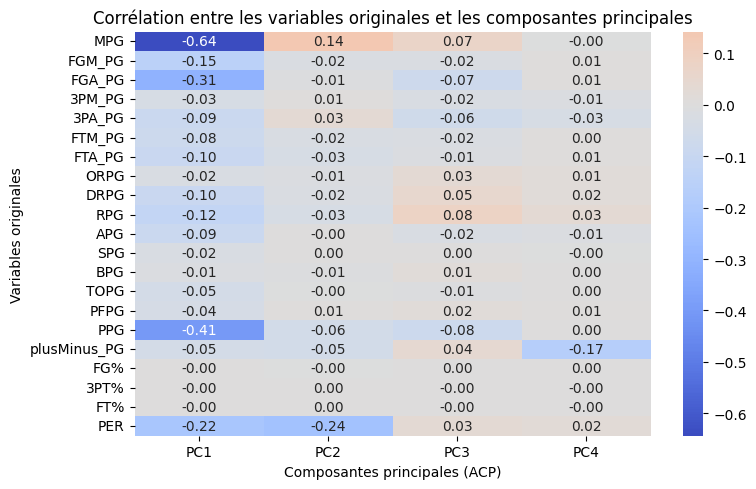

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.heatmap(cor_df, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Corrélation entre les variables originales et les composantes principales")
plt.xlabel("Composantes principales (ACP)")
plt.ylabel("Variables originales")
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

to_array = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

# Appliquer l’UDF pour transformer le vecteur en array
df_dense = result.withColumn("pca_array", to_array("PCA_features"))


df_2d = df_dense .withColumn("PC1", col("pca_array")[0]) \
              .withColumn("PC2", col("pca_array")[1])
              
data = df_2d.select("personName", "PC1", "PC2").collect()

# Construire une liste de tuples
rows = [(row["personName"], row["PC1"], row["PC2"]) for row in data]          

df_2d_pd = pd.DataFrame(rows, columns=["personName", "PC1", "PC2"])

print(df_2d_pd)



Py4JJavaError: An error occurred while calling o1057.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 377.0 failed 1 times, most recent failure: Lost task 0.0 in stage 377.0 (TID 1465) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 27 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:392)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:420)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:392)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 27 more


TypeError: 'Column' object is not callable

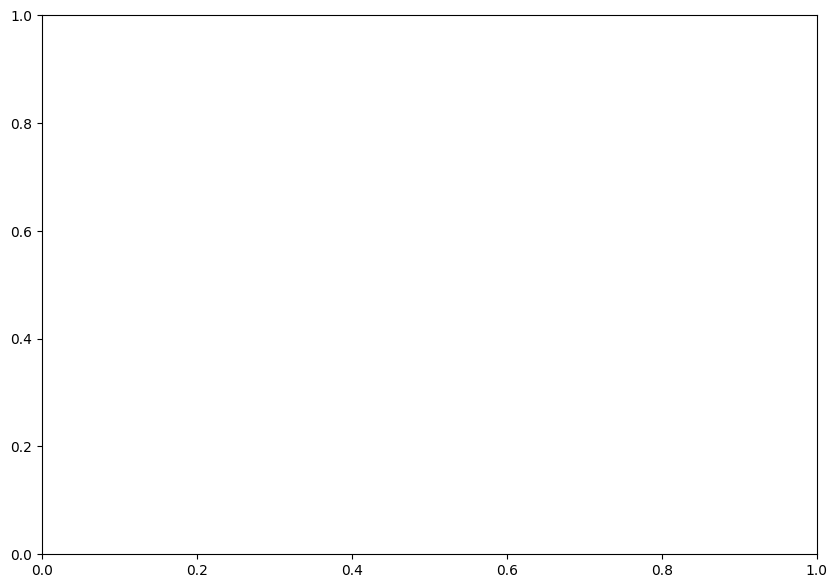

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(df_2d_pd["PC1"], df_2d_pd["PC2"], alpha=0.6)
plt.xlabel("PC1 (80.75%)")
plt.ylabel("PC2 (8.84%)")
plt.title("ACP des joueurs NBA (PC1 vs PC2)")

# Annoter les joueurs extrêmes (facultatif)
for i, row in df_2d_pd.iterrows():
    if abs(row["PC1"]) > 2 or abs(row["PC2"]) > 2:
        plt.text(row["PC1"], row["PC2"], row["player_name"], fontsize=8)

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.ml.clustering import KMeans

costs = []
for k in list(range(3,100)):
    kmeans = KMeans(k=k, seed=42, featuresCol="PCA_features", predictionCol='cluster')
    model = kmeans.fit(result)
    cost = model.summary.trainingCost  # Inertie (somme des distances aux centres)
    costs.append((k, cost))    
    

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\YANIS\Documents\Cours M2\PIR\code\myenv\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\YANIS\Documents\Cours M2\PIR\code\myenv\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\socket.py", line 708, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

[(3, 334968.5831746741), (4, 261382.569258266), (5, 229712.77409811408), (6, 207692.0412705018), (7, 194625.9968946857), (8, 177174.7014732543), (9, 168674.23698962724), (10, 155616.18314070988), (11, 146531.29666769953), (12, 141767.43535915794), (13, 135852.06305173427), (14, 128674.78014593768), (15, 124511.35201058789), (16, 122329.2178015717), (17, 117077.99990173441), (18, 112729.01553352903), (19, 111827.08669159852), (20, 107471.13200509394), (21, 105476.95603464574), (22, 103247.58489587567), (23, 100284.41052264441), (24, 97430.35013225656), (25, 95058.95849122728), (26, 92794.63973013387), (27, 91581.00096213704), (28, 90137.69884348988), (29, 87934.49373321075), (30, 86222.01065436323), (31, 86653.39910126843), (32, 83735.1729197879), (33, 82523.92369392638), (34, 81339.95938351558), (35, 79910.81370686766), (36, 78998.09526398387), (37, 77229.76144844381), (38, 76301.59155830389), (39, 75178.28302018056), (40, 74147.94567481034), (41, 73307.22841241494), (42, 72643.3332302

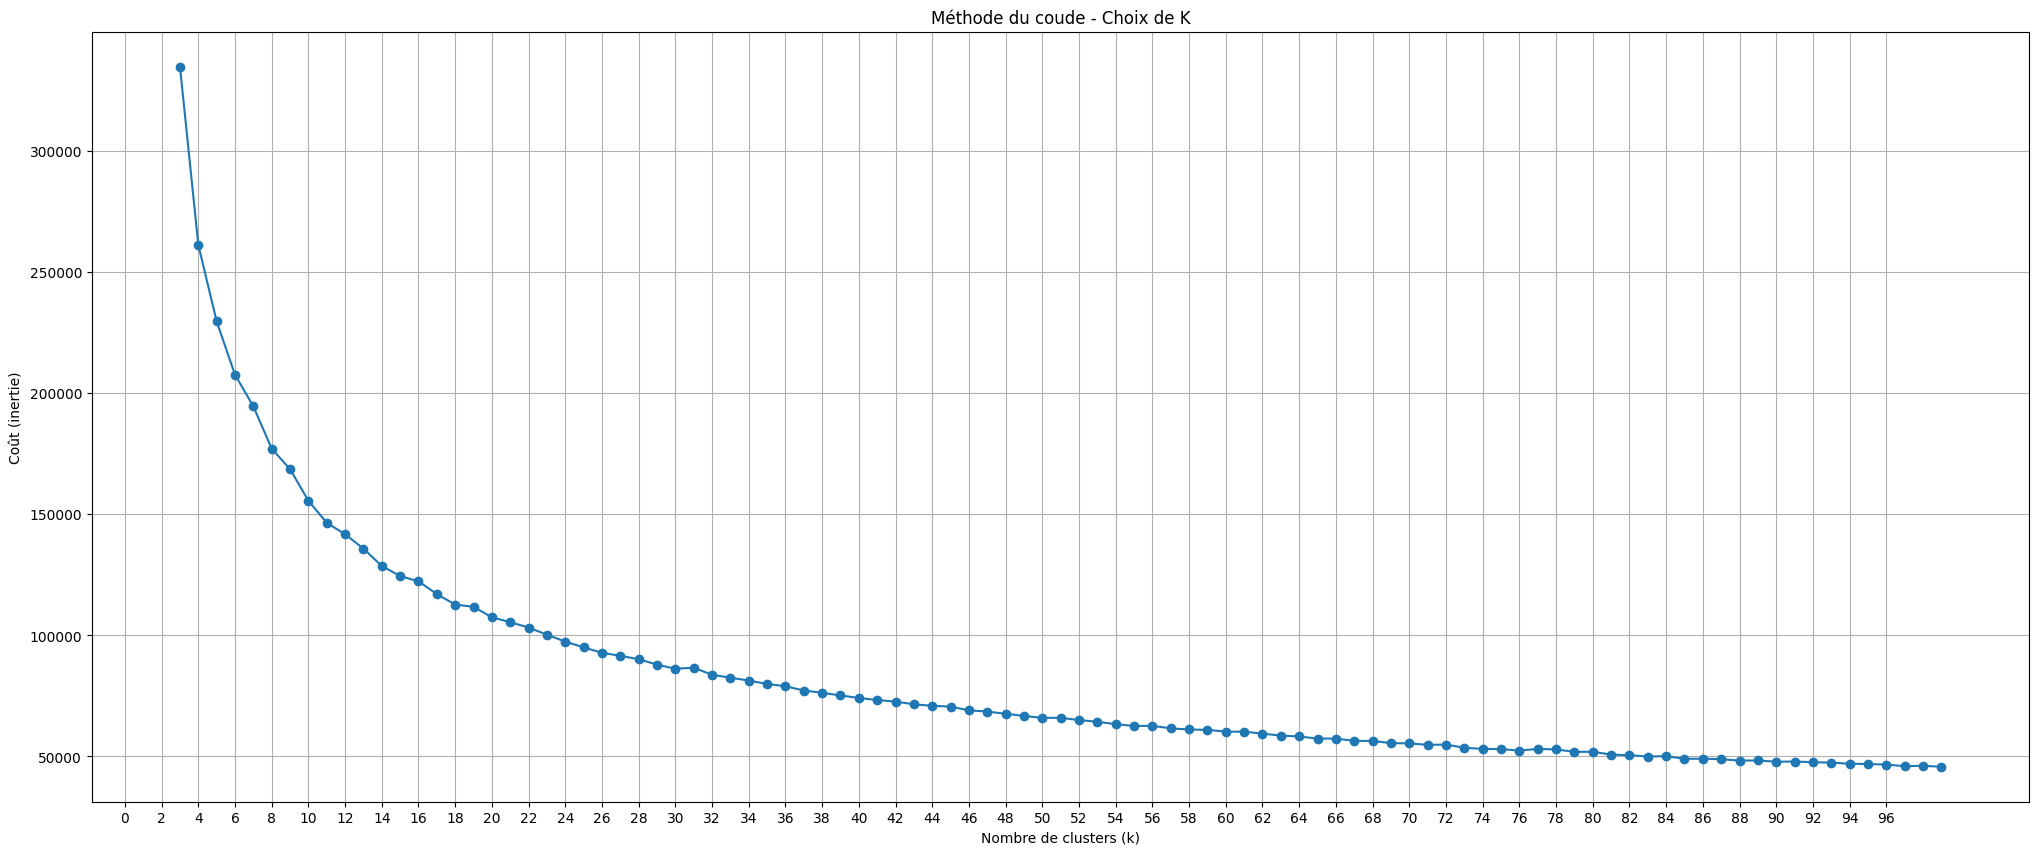

In [ ]:
import matplotlib.pyplot as plt

print(costs)
k_vals = [x[0] for x in costs]
cost_vals = [x[1] for x in costs]

plt.figure(figsize=(25,10))
plt.plot(k_vals, cost_vals, marker='o', scalex=True)
plt.xticks(range(0,len(costs),2))
plt.title("Méthode du coude - Choix de K")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Coût (inertie)")
plt.grid(True)
plt.show()

In [ ]:
from pyspark.ml.feature import PCA
import pandas as pd

kmeans = KMeans(k=10, seed=42, featuresCol="PCA_features", predictionCol='cluster')
model = kmeans.fit(result)

df_clusters = model.transform(result)

#pca = PCA(k=2, inputCol="features", outputCol="pca_features")
#pca_model = pca.fit(df_vect)
#pca_result  = pca_model.transform(df_vect)

#df_with_predictions = model.transform(pca_result)





Voici quelques exemples de modèles que tu peux utiliser pour analyser les meilleurs joueurs et construire la meilleure équipe possible :

- **Clustering (KMeans, Gaussian Mixture)** : pour regrouper les joueurs selon leurs profils statistiques et identifier des rôles/types de joueurs complémentaires.
- **Régression linéaire/ridge/lasso** : pour prédire l’impact d’un joueur sur la victoire ou le score d’une équipe à partir de ses statistiques individuelles.
- **Random Forest / Gradient Boosting** : pour évaluer l’importance des différentes statistiques dans la performance d’une équipe ou d’un joueur.
- **Analyse en composantes principales (PCA)** : pour réduire la dimensionnalité et visualiser les profils de joueurs.
- **Optimisation combinatoire (algorithmes génétiques, programmation linéaire)** : pour sélectionner la meilleure combinaison de joueurs sous contraintes (salaire, position, etc.).
- **Réseaux de neurones (MLP, auto-encoders)** : pour modéliser des interactions complexes entre joueurs et prédire la performance d’une équipe.

Tu peux combiner ces approches pour explorer différents axes d’analyse et de sélection.
Pour identifier quels types de joueurs sont complémentaires via le clustering :

- **Analyse des clusters** : Chaque cluster regroupe des joueurs aux profils statistiques similaires (scoreurs, défenseurs, passeurs, etc.). En examinant les moyennes des statistiques par cluster (`cluster_summary`), tu peux caractériser chaque type de joueur.
- **Complémentarité** : Les joueurs complémentaires appartiennent souvent à des clusters différents, apportant des compétences variées (ex : un meneur passeur + un intérieur rebondeur + un ailier scoreur).
- **Construction d’équipe** : Sélectionne des joueurs issus de clusters aux profils distincts pour couvrir un maximum de besoins (création, défense, tir extérieur, rebond, etc.).
- **Visualisation** : Utilise la PCA pour visualiser la répartition des clusters et repérer les combinaisons de profils éloignés sur le plan statistique.

En résumé, la complémentarité s’observe en combinant des joueurs issus de clusters aux caractéristiques différentes, ce qui permet d’équilibrer l’équipe sur plusieurs aspects du jeu.


In [ ]:
denver_2023 = result.filter((col('season_year') == '2022-23') & (col('teamName') == 'Nuggets'))
denver_2023_clusters = model.transform(denver_2023)


In [ ]:
df_inter = denver_2023_clusters.select('personName','PER','cluster').orderBy(col('PER').desc())

df_inter.show(5, truncate=False)

Py4JJavaError: An error occurred while calling o8139.showString.
: java.lang.OutOfMemoryError: Java heap space


In [ ]:
celtics_2024 = result.filter((col('season_year') == '2023-24') & (col('teamName') == 'Celtics'))
celtics_2024.show(3)
celtics_2024_clusters = model.transform(celtics_2024)
celtics_2024_clusters.select('personName','PER','cluster').orderBy(col('PER').desc()).show(15)

+-----------+--------+----------------+-----+-----------------+----------------------+--------------------+-------------------------+-----------------+----------------------+----+----+----+----------+---------+---------+------------+----------------+-----+------------------+----+----+----+------------------+--------------------+--------------------+
|season_year|teamName|      personName|  MPG|fieldGoalsMade_PG|fieldGoalsAttempted_PG|threePointersMade_PG|threePointersAttempted_PG|freeThrowsMade_PG|freeThrowsAttempted_PG|ORPG|DRPG| RPG|assists_PG|steals_PG|blocks_PG|turnovers_PG|foulsPersonal_PG|  PPG|plusMinusPoints_PG| FG%|3PT%| FT%|               PER|            features|        PCA_features|
+-----------+--------+----------------+-----+-----------------+----------------------+--------------------+-------------------------+-----------------+----------------------+----+----+----+----------+---------+---------+------------+----------------+-----+------------------+----+----+----+------

In [ ]:
warriors_2022 = result.filter((col('season_year') == '2021-22') & (col('teamName') == 'Warriors'))
warriors_2022.show(3)
warriors_2022_clusters = model.transform(warriors_2022)
warriors_2022_clusters.select('personName','PER','cluster').orderBy(col('PER').desc()).show(15)

+-----------+--------+--------------------+-----+-----------------+----------------------+--------------------+-------------------------+-----------------+----------------------+----+----+----+----------+---------+---------+------------+----------------+-----+------------------+----+----+----+------------------+--------------------+--------------------+
|season_year|teamName|          personName|  MPG|fieldGoalsMade_PG|fieldGoalsAttempted_PG|threePointersMade_PG|threePointersAttempted_PG|freeThrowsMade_PG|freeThrowsAttempted_PG|ORPG|DRPG| RPG|assists_PG|steals_PG|blocks_PG|turnovers_PG|foulsPersonal_PG|  PPG|plusMinusPoints_PG| FG%|3PT%| FT%|               PER|            features|        PCA_features|
+-----------+--------+--------------------+-----+-----------------+----------------------+--------------------+-------------------------+-----------------+----------------------+----+----+----+----------+---------+---------+------------+----------------+-----+------------------+----+----

In [ ]:
bucks_2021 = result.filter((col('season_year') == '2020-21') & (col('teamName') == 'Bucks'))
bucks_2021.orderBy(col('PER').desc()).show(8)
bucks_2021_clusters = model.transform(bucks_2021)
bucks_2021_clusters.select('personName','PER','cluster').orderBy(col('PER').desc()).show(15)

+-----------+--------+--------------------+-----+-----------------+----------------------+--------------------+-------------------------+-----------------+----------------------+----+----+-----+----------+---------+---------+------------+----------------+-----+------------------+----+----+----+------------------+--------------------+--------------------+
|season_year|teamName|          personName|  MPG|fieldGoalsMade_PG|fieldGoalsAttempted_PG|threePointersMade_PG|threePointersAttempted_PG|freeThrowsMade_PG|freeThrowsAttempted_PG|ORPG|DRPG|  RPG|assists_PG|steals_PG|blocks_PG|turnovers_PG|foulsPersonal_PG|  PPG|plusMinusPoints_PG| FG%|3PT%| FT%|               PER|            features|        PCA_features|
+-----------+--------+--------------------+-----+-----------------+----------------------+--------------------+-------------------------+-----------------+----------------------+----+----+-----+----------+---------+---------+------------+----------------+-----+------------------+----+-

In [ ]:
#df_clusters.select("PCA_features", "cluster").show(5, truncate=False)

df_clusters.printSchema()


root
 |-- season_year: string (nullable = true)
 |-- teamName: string (nullable = true)
 |-- personName: string (nullable = true)
 |-- MPG: double (nullable = true)
 |-- fieldGoalsMade_PG: double (nullable = true)
 |-- fieldGoalsAttempted_PG: double (nullable = true)
 |-- threePointersMade_PG: double (nullable = true)
 |-- threePointersAttempted_PG: double (nullable = true)
 |-- freeThrowsMade_PG: double (nullable = true)
 |-- freeThrowsAttempted_PG: double (nullable = true)
 |-- ORPG: double (nullable = true)
 |-- DRPG: double (nullable = true)
 |-- RPG: double (nullable = true)
 |-- assists_PG: double (nullable = true)
 |-- steals_PG: double (nullable = true)
 |-- blocks_PG: double (nullable = true)
 |-- turnovers_PG: double (nullable = true)
 |-- foulsPersonal_PG: double (nullable = true)
 |-- PPG: double (nullable = true)
 |-- plusMinusPoints_PG: double (nullable = true)
 |-- FG%: double (nullable = true)
 |-- 3PT%: double (nullable = true)
 |-- FT%: double (nullable = true)
 |-- f

In [ ]:
cluster_summary = df_clusters.groupBy("cluster").agg(
    mean("MPG").alias("avg_MPG"),
    mean("PPG").alias("avg_PPG"),
    mean("RPG").alias("avg_RPG"),
    mean("assists_PG").alias("avg_assists_PG"),
    mean("steals_PG").alias("avg_steals_PG"),
    mean("blocks_PG").alias("avg_blocks_PG"),
    mean("plusMinusPoints_PG").alias("avg_plus_minus"),
    count("personName").alias('nb_joueurs'),
    mean('PER').alias('PER')
)

# Afficher le résumé des clusters
cluster_summary.show()

+-------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+----------+------------------+
|cluster|           avg_MPG|           avg_PPG|           avg_RPG|     avg_assists_PG|     avg_steals_PG|      avg_blocks_PG|      avg_plus_minus|nb_joueurs|               PER|
+-------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+----------+------------------+
|      1|22.469538816295113| 7.742559569561882|3.3093312836279734| 1.8226902382782486|0.6613604919292848|0.36149884704073815|-0.47658724058416607|      1301|1058.6430274327447|
|      6|27.287017017017018|10.933073073073084|4.2736736736736765|  2.540350350350349|0.8472172172172175|0.44757757757757666|  -0.155935935935936|       999|1437.9944330230226|
|      3|30.357468354430395|13.975427215189896| 5.216455696202527|  3.069145569620254|0.9183069620253161| 0.5778481

In [ ]:
# Calculer la distribution des clusters
cluster_distribution = df_clusters.groupBy("cluster").count()

# Afficher la distribution des clusters
cluster_distribution.show()


+-------+-----+
|cluster|count|
+-------+-----+
|     12|  497|
|      1|  354|
|     13|  434|
|      6|  707|
|      3|  575|
|      5|  351|
|      9|    6|
|      4|  460|
|      8|  494|
|      7|  725|
|     10|  395|
|     11|  818|
|     14|  374|
|      2|  592|
|      0|  252|
+-------+-----+



In [ ]:
df_clusters.filter((col('cluster') == 2) & (col('season_year') == '2022-23')).orderBy('PER',ascending=False ).show(10)

+-----------+--------+--------------------+-----+-----------------+----------------------+--------------------+-------------------------+-----------------+----------------------+----+----+-----+----------+---------+---------+------------+----------------+-----+------------------+----+----+----+------------------+--------------------+--------------------+-------+
|season_year|teamName|          personName|  MPG|fieldGoalsMade_PG|fieldGoalsAttempted_PG|threePointersMade_PG|threePointersAttempted_PG|freeThrowsMade_PG|freeThrowsAttempted_PG|ORPG|DRPG|  RPG|assists_PG|steals_PG|blocks_PG|turnovers_PG|foulsPersonal_PG|  PPG|plusMinusPoints_PG| FG%|3PT%| FT%|               PER|            features|        PCA_features|cluster|
+-----------+--------+--------------------+-----+-----------------+----------------------+--------------------+-------------------------+-----------------+----------------------+----+----+-----+----------+---------+---------+------------+----------------+-----+---------

In [ ]:
df_clusters.filter(col('personName') == "Russell Westbrook").orderBy('season_year').show(20)

+-----------+--------+-----------------+-----+-----------------+----------------------+--------------------+-------------------------+-----------------+----------------------+----+----+-----+----------+---------+---------+------------+----------------+-----+------------------+----+----+----+------------------+--------------------+--------------------+-------+
|season_year|teamName|       personName|  MPG|fieldGoalsMade_PG|fieldGoalsAttempted_PG|threePointersMade_PG|threePointersAttempted_PG|freeThrowsMade_PG|freeThrowsAttempted_PG|ORPG|DRPG|  RPG|assists_PG|steals_PG|blocks_PG|turnovers_PG|foulsPersonal_PG|  PPG|plusMinusPoints_PG| FG%|3PT%| FT%|               PER|            features|        PCA_features|cluster|
+-----------+--------+-----------------+-----+-----------------+----------------------+--------------------+-------------------------+-----------------+----------------------+----+----+-----+----------+---------+---------+------------+----------------+-----+------------------

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Évaluer le clustering
evaluator = ClusteringEvaluator(metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette_score = evaluator.evaluate(df_clusters)
print(f"Silhouette Score: {silhouette_score}")


IllegalArgumentException: prediction does not exist. Available: season_year, teamName, personName, MPG, fieldGoalsMade_PG, fieldGoalsAttempted_PG, threePointersMade_PG, threePointersAttempted_PG, freeThrowsMade_PG, freeThrowsAttempted_PG, ORPG, DRPG, RPG, assists_PG, steals_PG, blocks_PG, turnovers_PG, foulsPersonal_PG, PPG, plusMinusPoints_PG, FG%, 3PT%, FT%, features, PCA_features, cluster

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.dataframe import *

plot_data = df_with_predictions.select("pca_features", "prediction").collect()
pandas_plot_data = pd.DataFrame(plot_data, columns=["pca_features", "prediction"])

pandas_plot_data["x"] = pandas_plot_data["pca_features"].apply(lambda v: v[0])
pandas_plot_data["y"] = pandas_plot_data["pca_features"].apply(lambda v: v[1])

pandas_plot_data.describe()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_plot_data, x="x", y="y", hue="prediction", palette="Set2", s=100)
plt.title("Clusters K-Means en 2D via PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


# Sélection des colonnes pour visualisation
plot_data = df_with_predictions.select("pca_features", "prediction").toPandas()

# Extraire les deux dimensions
plot_data["x"] = plot_data["pca_features"].apply(lambda v: v[0])
plot_data["y"] = plot_data["pca_features"].apply(lambda v: v[1])


In [ ]:
import matplotlib.pyplot as plt

print(costs)
k_vals = [x[0] for x in costs]
cost_vals = [x[1] for x in costs]

plt.figure(figsize=(8,5))
plt.plot(k_vals, cost_vals, marker='o')
plt.title("Méthode du coude - Choix de K")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Coût (inertie)")
plt.grid(True)
plt.show()


Ici commence le triatement des données

In [ ]:
team_names = teams.select("ABBREVIATION")
joined_games = games_df.join(teams, games_df.HOME_TEAM_ID == teams.TEAM_ID ).select(teams["ABBREVIATION"], games_df["*"] )

joined_games.show()

In [ ]:
rebounds_per_win = joined_games.groupBy("ABBREVIATION", "SEASON").agg(
    round(avg(when(joined_games["HOME_TEAM_WINS"] == 0, joined_games["REB_home"])), 2).alias('rebonds_per_lose'),
    round(avg(when(joined_games["HOME_TEAM_WINS"] == 1, joined_games["REB_home"])),2).alias("rebounds_per_win")
)
rebounds_per_win.show()

### Teste de regression logistic pour prédir la victoire d'un match ###

In [ ]:
import re 
regex = re.compile(r".*_away")


In [ ]:
df_games =  spark.read.csv("./games.csv", header=True, inferSchema=True)
colonnes = df_games.columns
from pyspark.sql.functions import *
max = df_games.select(max(df_games["SEASON"]))
max.show()
colonnes_a_conerver=[col for col in colonnes if not regex.match(col)] 
df_games = df_games.select(colonnes_a_conerver).drop('GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT','HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON','TEAM_ID_home')
print(df_games.count())
df_games = df_games.dropna()
print(df_games.count())
print(df_games.schema)


In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=[ 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home'], outputCol="features")
structured_df = assembler.transform(df_games)
train_data, test_data = structured_df.randomSplit([0.8,0.2], seed=42)

train_data.schema


In [ ]:
from pyspark.ml.classification import LogisticRegression
lr=LogisticRegression(featuresCol="features", labelCol="HOME_TEAM_WINS")
lr_model=lr.fit(train_data)

predictions = lr_model.transform(test_data)



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="HOME_TEAM_WINS")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Afficher les coefficients du modèle
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

In [ ]:
prediction_df = spark.read.csv("./games_22.csv", header=True, inferSchema=True).select(colonnes_a_conerver).drop( 'GAME_ID','GAME_DATE_EST', 'GAME_STATUS_TEXT','HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON','TEAM_ID_home')


data = prediction_df.limit(50)

data.show()

In [ ]:

vector_data = assembler.transform(data)
prediction = lr_model.transform(vector_data)


In [ ]:
prediction.select('HOME_TEAM_WINS', 'probability', 'prediction').show()